In [1]:
# modules imported
import numpy as np
import pandas as pd
from skimage import io
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import cv2
import os

In [2]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 637.6 kB/s eta 0:00:000:00:01


In [3]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
#from gradcam import VizGradCAM
from keras import backend as K
#import tensorflow.keras.backend as K
from keras.models import Sequential, load_model, Model

2024-04-12 08:19:45.973010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 08:19:45.973135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 08:19:46.114067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# path of the files
TRAIN_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train/'
TEST_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test/'

In [5]:
def createdf(DIR):
    classpath = glob(DIR+"*")    
    classpath.pop(1) # remove Pneumonia class to make it binary
    
    data=[]
    # listing the image filepaths
    for i in classpath:
        data += glob(i+"/*")
    print('Data length',len(data))
    df = pd.DataFrame(data, columns=['file_path'])
    
    # listing the classes   
    train_class = []
    for i in range(df.shape[0]):
        train_class.append(df['file_path'][i].split('/')[6])
    df['class'] = train_class
    
    print(df.head())
    
    # plotting the dataframe
    df['class'].value_counts().plot(kind='bar', grid=True)
    
    return df

In [6]:
# remove duplicates
def removeduplicates(df):
    new_df = df[['file_path','class']].drop_duplicates().reset_index()
    print(new_df.shape)
    return new_df

Data length 181
                                           file_path   class
0  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
1  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
2  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
3  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
4  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal


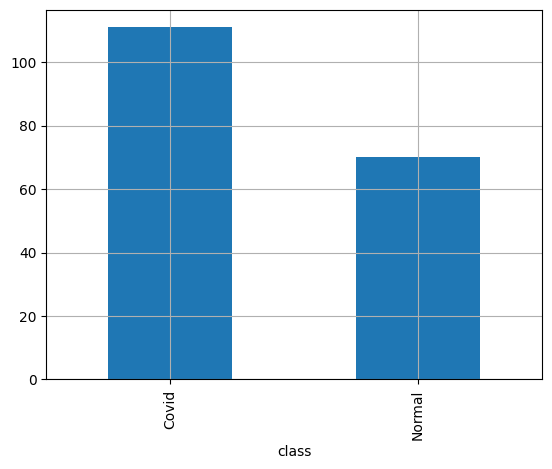

In [7]:
traindf = createdf(TRAIN_DIR)

In [8]:
traindf = removeduplicates(traindf)

(181, 3)


Data length 46
                                           file_path   class
0  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
1  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
2  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
3  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
4  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal


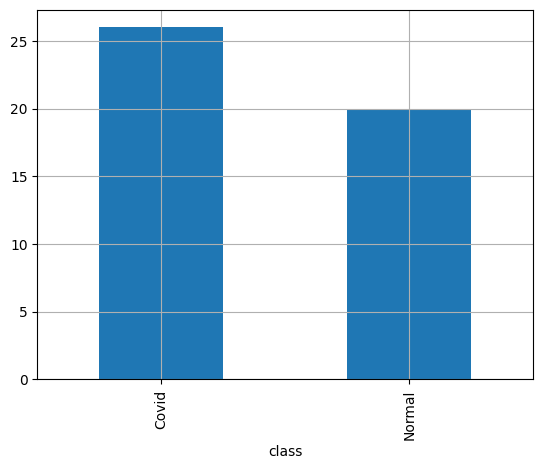

In [9]:
testdf = createdf(TEST_DIR)

In [10]:
traindf.loc[1, 'file_path']

'/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal/014.jpeg'

In [11]:
def plotimg(path):
    img = plt.imread(path)
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()

def plotimgcv(img):
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()
    

Shape of image -  (2074, 2380, 3)


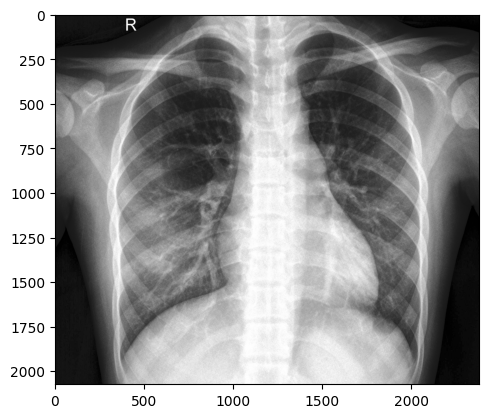

Class - Normal


In [12]:
# viz original images
plotimg(traindf.loc[1, 'file_path'])
print('Class -',traindf.loc[1, 'class'])

Shape of image -  (2382, 2746, 3)


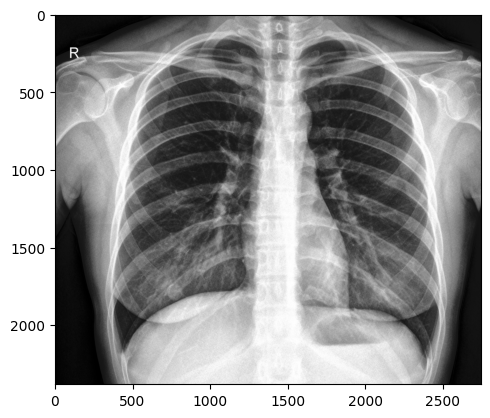

Class - Normal


In [13]:
plotimg(traindf.loc[18, 'file_path'])
print('Class -',traindf.loc[18, 'class'])

In [14]:
# unsharp masking 
def umasking(img):
    test=img.copy()
    smooth = cv2.GaussianBlur(test, (0, 0), 2.0)
    unsharp = cv2.addWeighted(test, 2, smooth, -1, 0)
    return unsharp

# histogram equalization
def histequal(img):
    test=img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(test)
    return cl1

# https://stackoverflow.com/questions/12023958/what-does-cvnormalize-src-dst-0-255-norm-minmax-cv-8uc1
def preprocess(img):
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_n = cv2.normalize(src=grayimage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    imgup = umasking(img_n)
    grayimg = histequal(imgup)
    rgbimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB)
    return rgbimg

Shape of image -  (2382, 2746, 3)


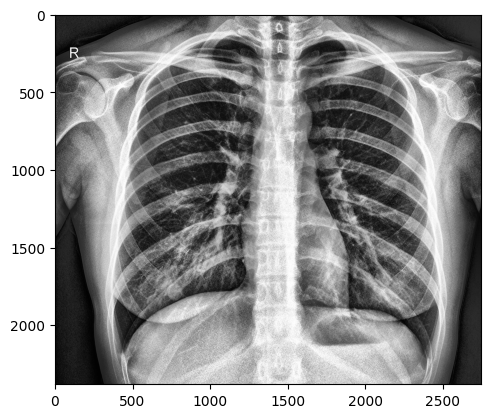

In [15]:
# test the preprocessing
img = cv2.imread(traindf.loc[18, 'file_path'], cv2.IMREAD_GRAYSCALE)
imgup = umasking(img)
imgup1 = histequal(imgup)
bgrimg = cv2.cvtColor(imgup1, cv2.COLOR_GRAY2BGR)
plotimgcv(bgrimg)

Shape of image -  (2382, 2746, 3)


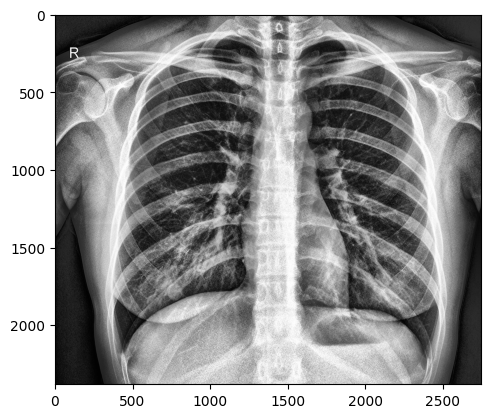

In [16]:
img = plt.imread(traindf.loc[18, 'file_path'])
img = preprocess(img)
plt.imshow(img)
print('Shape of image - ',np.array(img).shape)
plt.show()

In [17]:
# dataset parameters
CLASS_MODE = 'binary' 
TARGET_SIZE = (224,224)
EPOCHS = 5 
BATCH_SIZE = 6 

In [18]:
# preprocessing on each image
def create_datagen():
    return ImageDataGenerator(preprocessing_function = preprocess)
#                               rescale = 1./255,
#                               samplewise_center = True,
#                               samplewise_std_normalization = True)
#                             brightness_range=[0.2,1.2]) # brightness

In [19]:
#https://stackoverflow.com/questions/62662194/keras-imagedatagenerator-validation-split-not-selected-from-shuffled-dataset
# training
def create_train_gen(datagen, traindata):
    return datagen.flow_from_dataframe(
        traindata, 
#         directory=TRAIN_DIR,
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
#         subset='training'
    )

In [20]:
def create_val_gen(datagen, val_data): 
    return datagen.flow_from_dataframe(
        val_data, 
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

In [21]:
# test
def create_test_gen(datagen): 
    return datagen.flow_from_dataframe(
        testdf, 
#         directory=TEST_DIR,
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
#         subset='validation'
    )

In [22]:
from sklearn.model_selection import train_test_split
# split data into train and validation sets, small data sets let us do this
trainsplit, valsplit = train_test_split(traindf, test_size=0.2, random_state=42)

In [23]:
# preprocessed images
data_generator = create_datagen()
train_gen = create_train_gen(data_generator, trainsplit)
val_gen = create_val_gen(data_generator, valsplit)
test_gen = create_test_gen(data_generator)

Found 144 validated image filenames belonging to 2 classes.
Found 37 validated image filenames belonging to 2 classes.
Found 46 validated image filenames belonging to 2 classes.


The model for MobileNet

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define a MobileNet model
def build_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape = (224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='sigmoid')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='sigmoid')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = build_model()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


# training
history = model.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 4:39 12s/step - accuracy: 0.6667 - loss: 0.8882

I0000 00:00:1712910016.677872     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712910016.702555     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6416 - loss: 0.7133

W0000 00:00:1712910023.105454     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - accuracy: 0.6419 - loss: 0.7090 - val_accuracy: 0.5405 - val_loss: 0.5562
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6679 - loss: 0.5772 - val_accuracy: 0.7838 - val_loss: 0.4349
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8649 - loss: 0.3767 - val_accuracy: 0.8919 - val_loss: 0.3505
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.9283 - loss: 0.2885 - val_accuracy: 0.9189 - val_loss: 0.2352
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9095 - loss: 0.2028 - val_accuracy: 0.9189 - val_loss: 0.1940


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

W0000 00:00:1712910048.705797      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 547ms/step


W0000 00:00:1712910052.531980     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9749 - loss: 0.1580


W0000 00:00:1712910054.546153     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.11847850680351257
Test Accuracy: 0.97826087474823
Precision: 1.0
Recall: 0.95
F1-Score: 0.9743589743589743
ROC AUC Score: 1.0


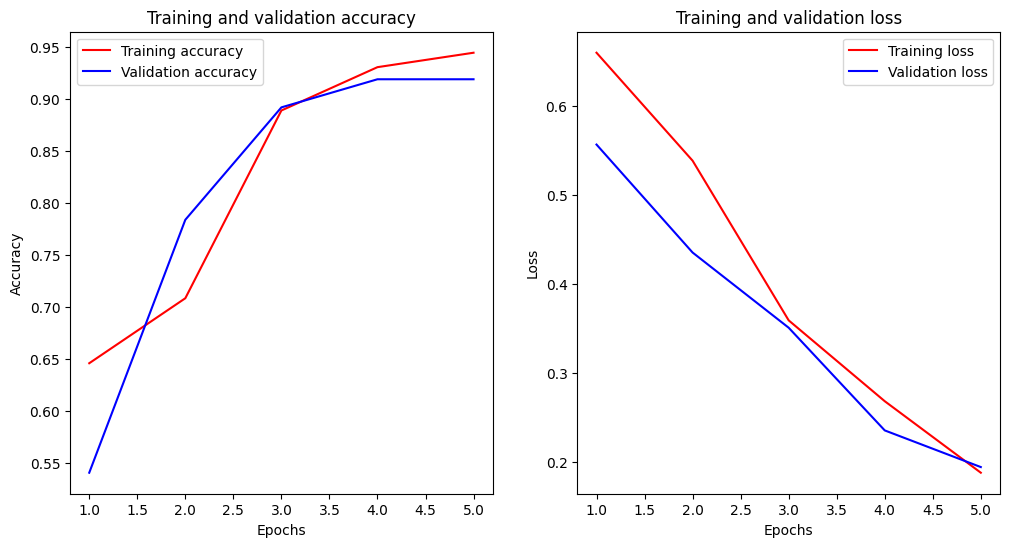

In [25]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for Vgg

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define your VGG model
def build_model1():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='sigmoid')(x)
    x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with our defined function
model1 = build_model1()
model1.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


# train the model
history = model1.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.7198 - loss: 0.7161 - val_accuracy: 0.9459 - val_loss: 0.2339
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9103 - loss: 0.2948 - val_accuracy: 0.9730 - val_loss: 0.2071
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9336 - loss: 0.2093 - val_accuracy: 0.9730 - val_loss: 0.1082
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.9704 - loss: 0.1194 - val_accuracy: 0.9730 - val_loss: 0.0868
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9628 - loss: 0.1383 - val_accuracy: 1.0000 - val_loss: 0.0631


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 965ms/step


W0000 00:00:1712910105.582696      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0485


W0000 00:00:1712910106.962968      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.04373126104474068
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC AUC Score: 1.0


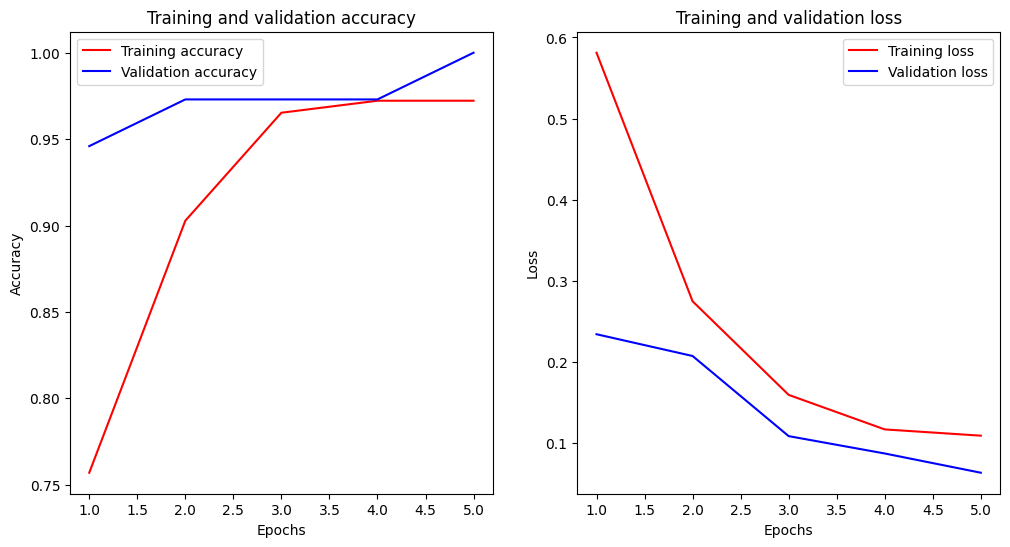

In [27]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model1.predict(test_gen)

# calculate and print metrics
loss, accuracy = model1.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for Resnet50

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define your ResNet model
def build_model2():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='sigmoid')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model using the above function
model2 = build_model2()
model2.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model2.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4352 - loss: 0.7437 

W0000 00:00:1712910127.356470      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6040 - loss: 0.6738

W0000 00:00:1712910134.135488     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 520ms/step - accuracy: 0.6101 - loss: 0.6676 - val_accuracy: 1.0000 - val_loss: 0.3942
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.8313 - loss: 0.4439 - val_accuracy: 0.9459 - val_loss: 0.1701
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9338 - loss: 0.2356 - val_accuracy: 0.9730 - val_loss: 0.0939
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9404 - loss: 0.1774 - val_accuracy: 0.9730 - val_loss: 0.0671
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9617 - loss: 0.1436 - val_accuracy: 1.0000 - val_loss: 0.0378


4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

W0000 00:00:1712910166.044084     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 940ms/step


W0000 00:00:1712910172.619760      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.9657 - loss: 0.0945


W0000 00:00:1712910175.536774     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.06354500353336334
Test Accuracy: 0.97826087474823
Precision: 1.0
Recall: 0.95
F1-Score: 0.9743589743589743
ROC AUC Score: 1.0


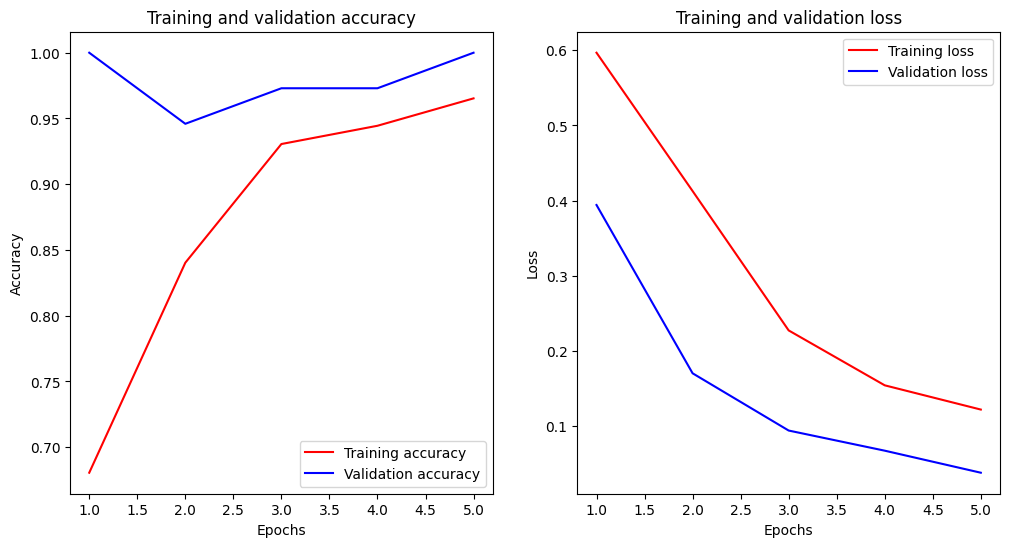

In [29]:
# evaluate the model with our test set
y_true = test_gen.classes
y_pred = model2.predict(test_gen)

# calculate and print metrics
loss, accuracy = model2.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for DenseNet

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we defined your DenseNet model
def build_model3():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='sigmoid')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='sigmoid')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with the above function
model3 = build_model3()
model3.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


# training the model
history = model3.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 12:49 33s/step - accuracy: 0.3333 - loss: 0.9119

W0000 00:00:1712910212.649415      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5927 - loss: 0.7043

W0000 00:00:1712910226.208936      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5992 - loss: 0.6951 - val_accuracy: 0.5405 - val_loss: 0.6816
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7464 - loss: 0.4866 - val_accuracy: 0.8919 - val_loss: 0.3408
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9458 - loss: 0.2751 - val_accuracy: 0.8919 - val_loss: 0.2420
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9081 - loss: 0.2249 - val_accuracy: 0.8919 - val_loss: 0.4053
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9192 - loss: 0.2215 - val_accuracy: 0.8919 - val_loss: 0.2211


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 

W0000 00:00:1712910275.602529     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


W0000 00:00:1712910292.188279      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 938ms/step - accuracy: 1.0000 - loss: 0.1419


W0000 00:00:1712910299.161990     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.09575531631708145
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC AUC Score: 1.0


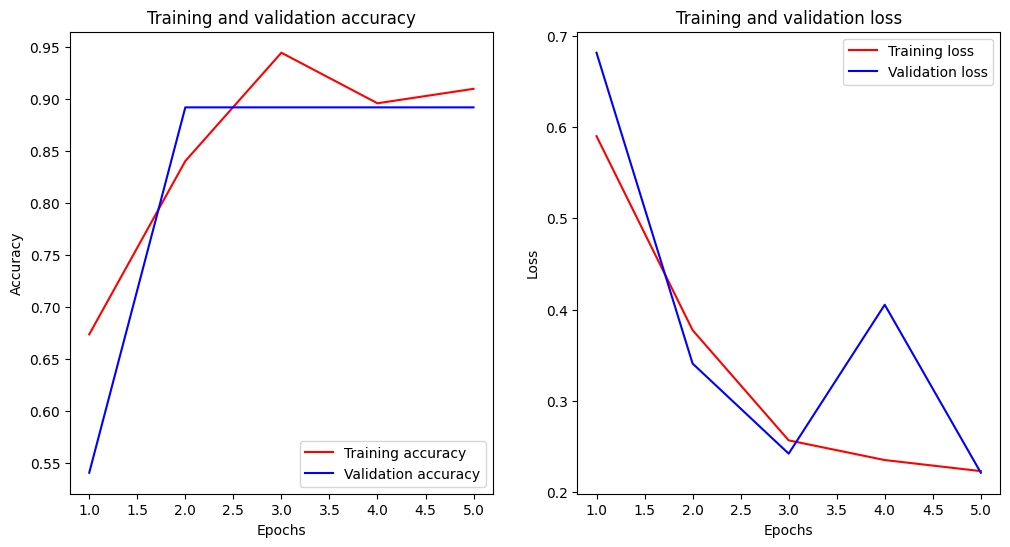

In [31]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model3.predict(test_gen)

# calculate and print the metrics
loss, accuracy = model3.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

GradCAM

In [64]:
def gradcam(lastconvlayer,img,gt,model):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(lastconvlayer).output, model.output])
    io_img = np.expand_dims(img, axis=0)
    print('Image shape -',io_img.shape)

    ###--Compute GRADIENT
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(io_img)
    ##--   Below is for multiclass
    #     if CLASS_INDEX is None:
    #         CLASS_INDEX = tf.math.round(predictions[0][0])
        class_channel = predictions[0]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(class_channel, conv_outputs)
    print('Gradients shape', grads.shape)
    print('Prediction', predictions)
    print('Ground truth', gt)
    
    # spatially average
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    # matmul the gradients with the convolution outputs
    heatmap = output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [60]:
# Below visualization code is from source = https://keras.io/examples/vision/grad_cam/
from IPython.display import Image, display
import matplotlib
import keras

def save_and_display_gradcam(heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image[0][0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

1. For Densenet

In [89]:
y_true = test_gen.classes
y_pred = model3.predict(test_gen)
# check which ones are incorrect preds
[i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[]

In [46]:
# model3.summary() 

Image shape - (1, 224, 224, 3)
Gradients shape (1, 7, 7, 32)
Prediction tf.Tensor([[0.8814209]], shape=(1, 1), dtype=float32)
Ground truth 1.0


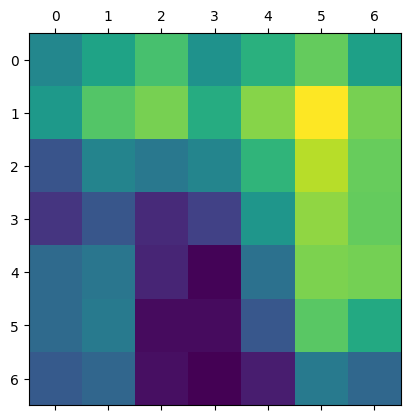

In [83]:
image = next(test_gen)
lastconvlayer = 'conv5_block16_2_conv'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], model3)

plt.matshow(heatmap)
plt.show()

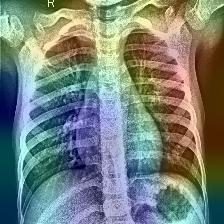

In [84]:
save_and_display_gradcam(heatmap)

2. For Mobilenet

In [90]:
y_true = test_gen.classes
y_pred = model.predict(test_gen)
# check which ones are incorrect preds
[i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[14]

In [92]:
# model.summary() 

Image shape - (1, 224, 224, 3)
Gradients shape (1, 7, 7, 1024)
Prediction tf.Tensor([[0.877131]], shape=(1, 1), dtype=float32)
Ground truth 1.0


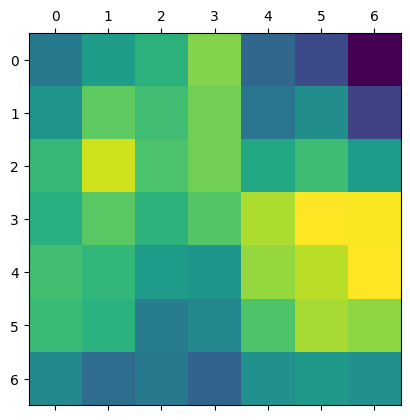

In [119]:
image = next(test_gen)
lastconvlayer = 'conv_pw_13'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], model)

plt.matshow(heatmap)
plt.show()

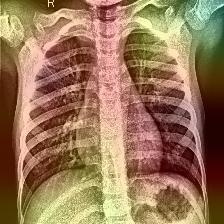

In [120]:
save_and_display_gradcam(heatmap)